# Drugs and medications correlation matrix

In [1]:
import difflib
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import seaborn as sns

%matplotlib inline

In [2]:
MIN_FREQ_MEDS = 25
MIN_FREQ_COND = 50
ODDS_RATIO_THRESHOLD = 10

## Relative Risk

The Relative Risk (RR) of observing a pair of diseases $i$ and $j$ affecting the same patient is given by

$$RR_ij = \frac{C_ijN}{P_iP_j}$$ where $C_ij$ is the number of patients affected by both diseases, $N$ is the total number of patients in the population and $P_i$ and $P_j$ are the prevalences of diseases $i$ and $j$.

In [12]:
from __future__ import division

def RR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    return round((c[i,j]*N)/(c[i,i]*c[j,j]), 2)

## Odds Ratio

In [4]:
def OR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    a = c[i,j]
    b = c[j,j] - c[i,j]
    c = c[i,i] - c[i,j]
    d = N - a
    return round((a*d)/(b*c), 2)

## Conditions database

In [5]:
con = pd.read_csv('../output/conditions/icd9_3/summary.csv')
con = con.loc[con.freq > MIN_FREQ_COND]
con = con.sort_values("codi")
con.rename(columns = {('desc'):('diagnosis')}, inplace=True)
con.head()

,codi,freq,diagnosis
8,041,864,Bacterial infection in conditions classified e...
16,199,410,"Malignant neoplasms, without specification of ..."
34,242,55,Thyrotoxicosis with or without goiter
15,244,450,Acquired hypothyroidism
18,246,246,Other disorders of thyroid


In [6]:
ds = pd.read_csv('../output/check/icd9_code3/data.csv')
ds_drop = ds.dropna().copy()
ds_drop.rename(columns=lambda x: x.replace('icd9_code3_', ''), inplace=True)
conditions = ds_drop.loc[:, np.append('entity_id', con.codi.values)]
conditions.head()

,entity_id,041,199,242,244,246,250,272,274,285,...,696,714,715,722,724,729,733,780,995,V83
0,=E00251427388221,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,=E00251428929421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429148221,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251429186521,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,=E00251429606721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Medication database

In [7]:
atc = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/inst/extdata/medications/ATC.csv', low_memory=False)
atc.rename(columns = {('text'):('medication')}, inplace=True)
atc.head()

,id,medication,parent
0,A,Alimentary tract and metabolism,NaN
1,A02,Drugs for acid related disorders,A
2,A02B,Drugs for treatment of peptic ulcer,A02
3,A02BC,Proton pump inhibitors,A02B
4,A02BC01,Omeprazole,A02BC


In [8]:
ds = pd.read_csv('../output/check/atc/data.csv')
ds_drop = ds.dropna().copy()
ds_drop.rename(columns=lambda x: x.replace('atc_', ''), inplace=True)
ds_drop.head()

,entity_id,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,R01,R02,R03,R05,R06,S01,V01,V03,V04,V07
0,=E00251427388221,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251428929421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429148221,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251429186521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251429606721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
meds = pd.melt(ds_drop, id_vars=["entity_id"], value_name="val")
meds = meds.groupby('variable').sum()
meds = meds[meds.val > MIN_FREQ_MEDS]
medications = ds_drop.loc[:, np.append('entity_id', meds.index.values)]
medications.head()

,entity_id,A02,A03,A06,A07,A10,A11,A12,B01,B03,...,N02,N03,N05,N06,N07,R01,R03,R05,R06,S01
0,=E00251427388221,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,=E00251428929421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429148221,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,=E00251429186521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251429606721,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Filter participants

In [10]:
phenotypes = pd.merge(medications, conditions, on='entity_id')

## Phenotypes GCAT and heritability

In [120]:
def get_coocurrences(phenotypes):
    
    phenotypes.drop('entity_id', 1, inplace=True)
    phenotypes_matrix = phenotypes.as_matrix().astype(int)
    coocurrences = phenotypes_matrix.T.dot(phenotypes_matrix)
    return coocurrences

In [121]:
heritability = pd.read_csv('../output/datasets/heritability/data.csv')
phenotypes_heritability = pd.merge(heritability[['entity_id']], phenotypes, how='left')

## Calculate comorbidity frequencies

In [122]:
coocurrences_gcat = get_coocurrences(phenotypes)
coocurrences_heritability = get_coocurrences(phenotypes_heritability)

## Calculate comorbidity relative risk

In [123]:
def calculate_rr(phenotypes, coocurrences):
    N = phenotypes.shape[0]
    risk = coocurrences.copy().astype(float)
    for i in range(0, coocurrences.shape[0], 1):
        for j in range(0, coocurrences.shape[1], 1):
            risk[i,j] = RR(coocurrences, N, i, j)
    risk = pd.DataFrame(risk, columns=phenotypes.columns, index=phenotypes.columns)
    return risk

def calculate_or(phenotypes, coocurrences):
    N = phenotypes.shape[0]
    risk = coocurrences.copy().astype(float)
    for i in range(0, coocurrences.shape[0], 1):
        for j in range(0, coocurrences.shape[1], 1):
            risk[i,j] = OR(coocurrences, N, i, j)
    risk = pd.DataFrame(risk, columns=phenotypes.columns, index=phenotypes.columns)
    return risk

In [124]:
risk = calculate_rr(phenotypes, coocurrences_gcat)

In [125]:
odds = calculate_or(phenotypes, coocurrences_gcat)

## Medications and drug matrices

In [126]:
medication_matrix_columns = medications.columns.drop('entity_id')
conditions_matrix_columns = conditions.columns.drop('entity_id')

risk = risk.loc[medication_matrix_columns][conditions_matrix_columns]
odds = odds.loc[medication_matrix_columns][conditions_matrix_columns]

In [127]:
def filterRR(df, RR):
    risk_df = pd.DataFrame(df)
    risk_df['condition'] = risk_df.index
    risk_df = pd.melt(risk_df, id_vars=['condition'])
    risk_df = risk_df[risk_df['value'] > RR].sort_values(by=['value'], ascending=[0])
    risk_df_pivot = risk_df.pivot(index='condition', columns='variable')['value']
    risk_df_pivot = risk_df_pivot.fillna(0)
    return risk_df_pivot

## Plot disease relative risk matrix

In [128]:
df = filterRR(risk, 0)
df = filterRR(odds, 0)

### Index and column names

In [129]:
df.index = atc[atc.id.isin(df.index)].medication + " (" + atc[atc.id.isin(df.index)].id + ")"

In [130]:
df.columns = con.loc[con.codi.isin(df.columns), 'diagnosis'] + " (" + df.columns + ")"

/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/pandas/computation/expressions.py:71: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  return op(a, b)


In [131]:
df.head()

diagnosis,Bacterial infection in conditions classified elsewhere and of unspecified site (041),"Malignant neoplasms, without specification of site (199)",Thyrotoxicosis with or without goiter (242),Acquired hypothyroidism (244),Other disorders of thyroid (246),Diabetes mellitus (250),Disorders of lipoid metabolism (272),Gout (274),Other and unspecified anemias (285),"Anxiety, dissociative and somatoform disorders (300)",...,Psoriasis and similar disorders (696),Rheumatoid arthritis and other inflammatory polyarthropathies (714),Osteoarthrosis and allied disorders (715),Intervertebral disc disorders (722),Other and unspecified disorders of back (724),Other disorders of soft tissues (729),Other disorders of bone and cartilage (733),General symptoms (780),Certain adverse effects not elsewhere classified (995),Genetic carrier status (V83)
Drugs for acid related disorders (A02),4.26,1.19,0.46,0.83,1.56,1.75,2.36,2.42,2.99,2.64,...,1.38,2.44,2.22,2.54,3.7,5.76,1.76,3.23,1.92,2.28
Drugs for functional gastrointestinal disorders (A03),4.20,0.00,0.00,1.39,5.26,1.01,3.39,0.00,0.00,7.93,...,0.90,3.62,0.00,0.00,0.0,8.33,0.99,5.02,1.42,0.00
Laxatives (A06),0.00,0.00,0.00,2.98,5.45,1.04,1.63,0.00,0.00,2.93,...,0.00,3.75,2.99,0.00,0.0,0.00,4.57,1.61,0.91,0.00
Antidiarrheals (A07),0.99,0.00,0.00,0.00,0.00,0.00,1.13,0.00,0.00,0.91,...,1.90,3.22,0.00,6.33,0.0,2.67,1.35,0.00,1.25,2.41
Drugs used in diabetes (A10),1.04,1.21,1.95,1.10,0.88,1003.43,6.32,2.39,1.41,0.96,...,1.39,2.19,0.75,0.00,0.0,1.04,1.24,1.24,1.35,1.92


### Cluster map

In [132]:
df_filtered = df[df > 1].dropna(how="all", axis=0).dropna(how="all", axis=1)
df_filtered = df_filtered.fillna(df)

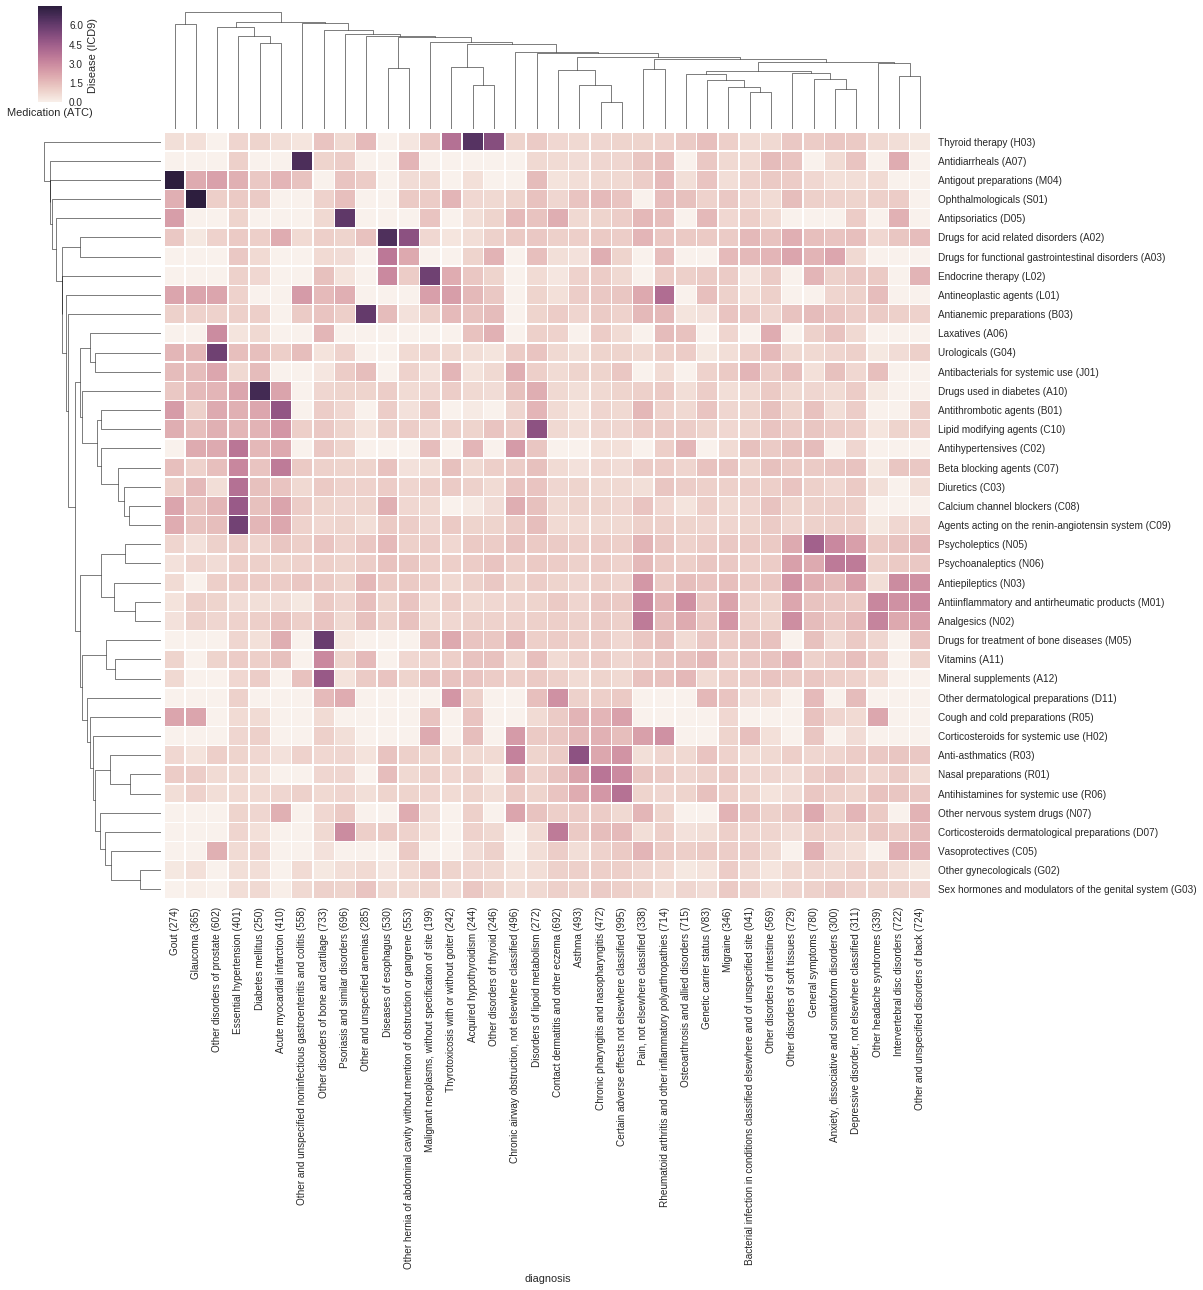

In [133]:
df_filtered_plot = log1p(df_filtered)
cg = sns.clustermap(df_filtered_plot, linewidths=.5, figsize=(16, 16))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.xlabel('Medication (ATC)')
plt.ylabel('Disease (ICD9)')
plt.savefig('../output/datasets/gcat-heritability/clustermap.png', bbox_inches="tight")
cg

### OR table

In [134]:
df_filtered.reset_index(level=0, inplace=True)
df_filtered = pd.melt(df_filtered, id_vars=["index"], var_name="diagnosis", value_name="or")
df_filtered.rename(columns = {('index'):('medication')}, inplace=True)
df_filtered = df_filtered.sort_values(['diagnosis', 'or'], ascending=[True, False])[['diagnosis', 'medication', 'or']]
df_filtered['diagnosis_code'] = df_filtered['diagnosis'].apply(lambda st: st[st.find("(")+1:st.find(")")])
df_filtered['medication_code'] = df_filtered['medication'].apply(lambda st: st[st.find("(")+1:st.find(")")])
df_filtered.head()

,diagnosis,medication,or,diagnosis_code,medication_code
143,Acquired hypothyroidism (244),Thyroid therapy (H03),621.13,244,H03
129,Acquired hypothyroidism (244),Antihypertensives (C02),4.66,244,C02
145,Acquired hypothyroidism (244),Antineoplastic agents (L01),4.18,244,L01
142,Acquired hypothyroidism (244),Corticosteroids for systemic use (H02),3.58,244,H02
122,Acquired hypothyroidism (244),Laxatives (A06),2.98,244,A06


In [135]:
def get_interaction_count(row, m):
    return m[row['medication_code']][row['diagnosis_code']]

def get_diagnosis_count(row, m):
    return m[row['diagnosis_code']][row['diagnosis_code']]

In [136]:
df_filtered_count = df_filtered.copy()
coocurrences_matrix = pd.DataFrame(coocurrences_gcat, columns=phenotypes.columns, index=phenotypes.columns)
coocurrences_matrix_heritability = pd.DataFrame(coocurrences_heritability, columns=phenotypes.columns, index=phenotypes.columns)

df_filtered_count['interaction_count'] = df_filtered_count.apply(get_interaction_count, axis=1, m=coocurrences_matrix)
df_filtered_count['diagnosis_count'] = df_filtered_count.apply(get_diagnosis_count, axis=1, m=coocurrences_matrix)
df_filtered_count['interaction_count_heritability'] = df_filtered_count.apply(get_interaction_count, axis=1, m=coocurrences_matrix_heritability)
df_filtered_count['diagnosis_count_heritability'] = df_filtered_count.apply(get_diagnosis_count, axis=1, m=coocurrences_matrix_heritability)
df_filtered_count

,diagnosis,medication,or,diagnosis_code,medication_code,interaction_count,diagnosis_count,interaction_count_heritability,diagnosis_count_heritability
143,Acquired hypothyroidism (244),Thyroid therapy (H03),621.13,244,H03,407,439,103,110
129,Acquired hypothyroidism (244),Antihypertensives (C02),4.66,244,C02,4,439,0,110
145,Acquired hypothyroidism (244),Antineoplastic agents (L01),4.18,244,L01,3,439,1,110
142,Acquired hypothyroidism (244),Corticosteroids for systemic use (H02),3.58,244,H02,3,439,1,110
122,Acquired hypothyroidism (244),Laxatives (A06),2.98,244,A06,2,439,1,110
125,Acquired hypothyroidism (244),Vitamins (A11),2.94,244,A11,12,439,2,110
128,Acquired hypothyroidism (244),Antianemic preparations (B03),2.86,244,B03,11,439,2,110
149,Acquired hypothyroidism (244),Drugs for treatment of bone diseases (M05),2.84,244,M05,6,439,1,110
157,Acquired hypothyroidism (244),Cough and cold preparations (R05),2.69,244,R05,2,439,0,110
126,Acquired hypothyroidism (244),Mineral supplements (A12),2.66,244,A12,14,439,2,110


In [137]:
df_filtered_count = df_filtered_count[df_filtered_count['or'] > ODDS_RATIO_THRESHOLD]
df_filtered_count = df_filtered_count[
    ['diagnosis',
     'medication',
     'or',
     'diagnosis_count',
     'interaction_count',
     'diagnosis_count_heritability',
     'interaction_count_heritability',
     'diagnosis_code',
     'medication_code'
    ]
]

In [138]:
df_filtered_count

,diagnosis,medication,or,diagnosis_count,interaction_count,diagnosis_count_heritability,interaction_count_heritability,diagnosis_code,medication_code
143,Acquired hypothyroidism (244),Thyroid therapy (H03),621.13,439,407,110,103,244,H03
647,Acute myocardial infarction (410),Antithrombotic agents (B01),133.82,64,32,22,13,410,B01
652,Acute myocardial infarction (410),Beta blocking agents (C07),34.25,64,24,22,12,410,C07
655,Acute myocardial infarction (410),Lipid modifying agents (C10),13.16,64,31,22,11,410,C10
393,"Anxiety, dissociative and somatoform disorders...",Psychoanaleptics (N06),35.51,447,298,129,91,300,N06
392,"Anxiety, dissociative and somatoform disorders...",Psycholeptics (N05),21.83,447,203,129,54,300,N05
756,Asthma (493),Anti-asthmatics (R03),156.03,969,396,264,120,493,R03
1398,Certain adverse effects not elsewhere classifi...,Antihistamines for systemic use (R06),44.41,3084,616,775,150,995,R06
1395,Certain adverse effects not elsewhere classifi...,Nasal preparations (R01),19.47,3084,214,775,60,995,R01
1396,Certain adverse effects not elsewhere classifi...,Anti-asthmatics (R03),14.50,3084,328,775,92,995,R03


In [139]:
df_filtered_count.to_csv('../output/check/icd9_atc/odds-ratio.csv', index = False)
df_filtered_count.to_csv('../output/datasets/gcat-heritability/odds-ratio.csv', index = False)

## Create phenotypes from associations

In [140]:
phenotypes = pd.merge(medications, conditions, on='entity_id')
phenotypes.head()

,entity_id,A02,A03,A06,A07,A10,A11,A12,B01,B03,...,696,714,715,722,724,729,733,780,995,V83
0,=E00251413459521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251413493621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251413493821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251415245521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251415248321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [141]:
for i in df_filtered_count.index:
    diag = df_filtered_count.loc[i, 'diagnosis_code']
    medi = df_filtered_count.loc[i, 'medication_code']
    field_name = diag + '_' + medi
    phenotypes[field_name] = phenotypes[diag]*phenotypes[medi]

phenotypes.head()

,entity_id,A02,A03,A06,A07,A10,A11,A12,B01,B03,...,338_N02,338_M01,338_N03,696_D05,696_D07,714_L01,714_H02,242_H03,242_D11,242_L01
0,=E00251413459521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251413493621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251413493821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251415245521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251415248321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
combined = phenotypes[phenotypes.columns[phenotypes.columns.str.contains('_')]]
combined.head()

,entity_id,244_H03,410_B01,410_C07,410_C10,300_N06,300_N05,493_R03,995_R06,995_R01,...,338_N02,338_M01,338_N03,696_D05,696_D07,714_L01,714_H02,242_H03,242_D11,242_L01
0,=E00251413459521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251413493621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251413493821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251415245521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251415248321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
combined.to_csv('../output/check/icd9_atc/data.csv', index = False)

## Group associations by diagnosis

`Rscript /home/labs/dnalab/share/lims/R/gcat-cleaning-data/R/check/check-icd9-atc.R`